# Masks v3.0

Integration with IB2306 layouts and layers organization.

## Packages

In [66]:
import numpy as np 
import matplotlib.pyplot as plt 
import phidl.geometry as pg
from phidl import quickplot as qp, set_quickplot_options
from phidl import Device
from itertools import product 
from scipy.optimize import minimize, newton 
from shapely.geometry import Polygon
import flatspin

## Layers

In [67]:
l_layers=2
l_grid = 3
l_design = 10
l_radialguides = 5
l_vis = 6
l_2 = 5
l_wafer=1

## Definitions

In [68]:
fov = (125e3, 100e3)
X=9
Y=9

## Functions

### ASI model from flatspin

Returns the position and angle of the element of an ASI in Pinwheel model

In [69]:
class CSPinwheel(flatspin.model.SpinIce):
    def __init__(self, cs = 1,**kwargs):
        self.cs = cs

        super().__init__(**kwargs)

    def _init_geometry(self):
        size = self.size
        lattice_spacing = self.lattice_spacing

        pos = flatspin.model.PinwheelSpinIceDiamond(size = size).pos
        angle = flatspin.model.PinwheelSpinIceDiamond(size = size).angle

        pos[:, 0] = pos[:, 0]*self.cs

        return pos, angle

    _vertex_size=(3, 3)

    @property
    def _default_cell_size(self):
        return (self.lattice_spacing/2, self.lattice_spacing/2)

### Element
Creates the stadium shape design as element.

In [70]:
def element(len, wid, lay=l_design): 
    p = wid
    element_parts = pg.rectangle(size=(len-p, wid), layer = lay).movex(0, p/2)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(0, p/2).movey(0, p/2)
    element_parts << pg.circle(radius = p/2, layer = lay).movex(p/2, len).movey(0, p/2)

    element = pg.union(element_parts, layer = lay)

    element.name = f'element_size-{len}-{wid}_p-{p}'

    if len<wid: 
        return Device()
    return element

### Grid

In [71]:
def grid(w, h, wid = 0.5e3, len = 15e3, fov = fov): 
    grid1 = pg.L(width = wid/2, size = (len/2, len/2), layer = l_grid)
    grid1 << pg.L(width = wid/2, size = (len/2, len/2), layer = l_grid).rotate(180).move((fov[0]-wid/2, fov[1]-wid/2))
    grid1 << pg.L(width = wid/2, size = (len/2, len/2), layer = l_grid).rotate(90).move((fov[0]-wid/2, 0))
    grid1 << pg.L(width = wid/2, size = (len/2, len/2), layer = l_grid).rotate(270).move((0, fov[1]-wid/2))
    grid1.xmin, grid1.ymin = 0, 0
    grid_list = [grid1]*h*w
    grid = pg.grid(grid_list, spacing = (0, 0), shape = (w, h))
    return grid

### Radial guides

In [72]:
def rad_guides(X, Y,fov,num_lines=100, line_width=1e3, diameter=10000e3, dash_width=10e3, layer=l_radialguides):
    radials = pg.litho_star(
        num_lines = num_lines,
        line_width = line_width,
        diameter = diameter,
        layer = layer
        )
    
    inner_box_x = (X)*fov[0]
    inner_box_y = (Y)*fov[1]

    radguides = pg.boolean(radials, pg.bbox([[-inner_box_x/2, -inner_box_y/2], [inner_box_x/2, inner_box_y/2]]), operation='not')

    min_radius = int(min(inner_box_x, inner_box_y)/2)
    max_radius = int(diameter/2)

    N_arcs = int((max_radius - min_radius)/(dash_width*2))
    arcs = Device()

    for r in np.linspace(min_radius, max_radius, N_arcs+1):
        arcs.add_ref(pg.arc(radius = r, width = dash_width, theta = 180, layer = 1)).rotate(-90)

    radguides = pg.boolean(radguides, arcs, layer=layer, operation="not")

    radguides.center = (0,0)
    
    return radguides

### Visible marks

In [73]:
def bot_left_mark(Design_,fov=fov,X=X,Y=Y):
    bottom_left = pg.L(width=200e3, size=(500e3,500e3), layer=l_vis).rotate(180)
    bottom_left.move(origin=(bottom_left.xmax, bottom_left.ymax), destination=(Design_.xmin-X*fov[0]/3,Design_.ymin-Y*fov[1]/3))
    return bottom_left

def bot_right_mark(Design_,fov=fov,X=X,Y=Y):
    bottom_right = pg.L(width=200e3, size=(500e3,500e3), layer=l_vis).rotate(-90)
    bottom_right.move(origin=(bottom_right.xmin, bottom_right.ymax), destination=(Design_.xmax+X*fov[0]/3,Design_.ymin-Y*fov[1]/3))
    return bottom_right

def upper_mark(Design_,fov=fov,X=X,Y=Y):
    upper = pg.straight(size=(500e3,200e3), layer=l_vis)    
    upper.move(origin=(upper.x, upper.ymin), destination=(Design_.x,Design_.ymax+Y*fov[1])) #check the upper one
    return upper

### Design functions
Insert the element in the positions and angles, also check the separation and adjust the ASI

In [74]:
def device_from_lists(coords, angles, element = None, scale = 1, radians = 1):
    # Adds elements at specified coordinates and angles
    # If no element is specified, adds rectangle of 220 by 80 
    assert len(coords) == len(angles), "Number of coordinates and angles must match"
    coords *= scale
    if radians:
        #convert to deg
        angles = np.degrees(angles)
        
    if not element:
        element = pg.rectangle(size = (220, 80))
    element.move(-element.center) # Center element on (0, 0)
    
    D = Device()
    for coord, angle in zip(coords, angles):
        D << pg.copy(element).rotate(angle).move(coord)

    return D


def stretched_array(sizex = 1, sizey = 1, pitchx = 1, pitchy = 1):
    
    offsetx = pitchx / 2
    offsety = pitchy / 2
    
    xh, xv = np.arange(offsetx, sizex*pitchx, pitchx), np.arange(0, (1+sizex)*pitchx, pitchx)
    yh, yv = np.arange(0, (1+sizey)*pitchy, pitchy), np.arange(offsety, sizey*pitchy, pitchy)

    harray = np.array(np.meshgrid(xh, yh))
    varray = np.array(np.meshgrid(xv, yv))
    
    harray = np.vstack([harray[0].flatten(), harray[1].flatten()]).transpose()
    varray = np.vstack([varray[0].flatten(), varray[1].flatten()]).transpose()

    return harray, varray

def array_angle(array, angle):
    angles = np.ones((len(array), 1))
    angles *= np.deg2rad(angle)
    
    return angles

def return_spacing(pitch, angle,  element=element(220, 80)):
    hpos, vpos = stretched_array(1, 1, 1, 1)
    h_array_angles = array_angle(hpos, angle)
    v_array_angles = array_angle(vpos, angle+90)
    coords = np.concatenate([hpos, vpos])
    angles = np.concatenate([h_array_angles, v_array_angles])
    
    D = device_from_lists(coords, angles, element=element, scale=pitch)
#     plot_device(D, plot_centers=True)
    p0, p1, p2 = [Polygon(p) for p in D.get_polygons()[0:3]]
#     print("dist", p0.distance(p1), p1.distance(p2))
    return p1.distance(p2)

def calc_spacing(spacing, angle, element=element(220, 80), tolerance=0.001):
    s = spacing
    
    scale0 = element.xsize*1.0+element.ysize*0.5
    def scale_func(scale):
        return np.abs(s-return_spacing(scale, angle, element=element))
    scale = newton(scale_func, scale0, rtol=tolerance)
    
    return scale

def calc_matrix_size(lenght, angle, dimen=12e3):
    sin = np.sin(np.deg2rad(angle))
    y=lenght*sin
    x = int(np.ceil(dimen/y)) # round a number to the next entire
    if x<20:
        x=20 # limiting the minimum size of the matrix
    elif x>90:
        x=90 #limiting the maximum size of the matrix

    return x

def crea_sample(leng, widt, separation, mat_size = (50,50), text_layer=l_layers, des_layer=l_design,angle=45):
    mat_prop=CSPinwheel(size=mat_size, cs=1)
    pos_=mat_prop.pos
    ang_=mat_prop.angle

    new_sample=device_from_lists(pos_, ang_, element(leng,widt, des_layer), scale=calc_spacing(separation,angle,element=element(leng,widt)))
    label=pg.text(f'({leng},{widt},{separation})mat={mat_size}',size=5e2,font="Arial",layer=text_layer,justify='center')
    label.movex(new_sample.xsize/2).movey(new_sample.ysize+500)
    new_sample << label

    return new_sample

def multi_size_sep(sizes, separations, angle, layer, Title):
    MultiDesign = []
    for s in sizes:
        sLe=s[0]
        sWi=s[1]
        for i in separations:
            x=calc_matrix_size(sLe, angle)
            sample=crea_sample(sLe, sWi, i, (x,x), des_layer=layer, angle=angle)
            MultiDesign.append(sample)

    gridded=pg.grid(MultiDesign,spacing=(5e3,5e3),shape=(len(separations),len(sizes)))
    title=pg.text(Title, size=5e3, justify="center", layer=l_layers,font="Arial")
    title.movey(gridded.ymax+20e3).movex(gridded.xsize/2)
    gridded<<title
    g=grid(3,1)
    g.center = gridded.center
    gridded<<g
    gridded.center = (0,0)

    return gridded

def multi_sep(size, separations, angle, layer, Title):
    MultiDesign = []
    sLe=size[0]
    sWi=size[1]
    for i in separations:
        x=calc_matrix_size(sLe, angle)
        sample=crea_sample(sLe, sWi, i, (x,x), des_layer=layer, angle=angle)
        MultiDesign.append(sample)

    gridded=pg.grid(MultiDesign,spacing=(5e3,5e3),shape=(len(separations),len(sizes)))
    title=pg.text(Title, size=5e3, justify="center", layer=l_layers,font="Arial")
    title.movey(gridded.ymax+10e3).movex(gridded.xsize/2)
    gridded<<title
    g=grid(3,1)
    g.center = gridded.center
    gridded<<g
    gridded.center = (0,0)

    return gridded

def scribe_marks(scribe_mark_width=40e3, scribe_mark_length=500e3, scribe_layer=l_grid):

    scribe_marks = Device()
    scribe_marks01 = Device()
    scribe_marks02 = Device()
    scribe_marks03 = Device()

    s1=pg.cross(length=scribe_mark_length, width=scribe_mark_width, layer=scribe_layer)
    s2=pg.copy(s1).movey(-10e6)
    s3=pg.copy(s1).movey(10e6)

    scribe_marks01<<s1
    scribe_marks01<<s2
    scribe_marks01<<s3

    scribe_marks02=pg.copy(scribe_marks01).movex(-10e6)
    scribe_marks03=pg.copy(scribe_marks01).movex(10e6)

    scribe_marks<<scribe_marks01
    scribe_marks<<scribe_marks02
    scribe_marks<<scribe_marks03

    return scribe_marks

def scribe_center_scribe_marks(scribe_mark_width=20e3, scribe_mark_length=400e3, scribe_layer=l_grid):
    scribe_marks = Device()
    scribe_marks01 = Device()
    scribe_marks02 = Device()

    s1=pg.cross(length=scribe_mark_length, width=scribe_mark_width, layer=scribe_layer)
    s2=pg.copy(s1).movey(-10e6)

    scribe_marks01<<s1
    scribe_marks01<<s2

    scribe_marks02=pg.copy(scribe_marks01).movex(-10e6)

    scribe_marks<<scribe_marks01
    scribe_marks<<scribe_marks02

    scribe_marks.center = (0,0)

    return scribe_marks

def samp_mode(sizes, separations, angle, mode="single"):
    assemble=Device()
    Final=Device()
    if mode=="multi":
        design_01=multi_size_sep(sizes, separations, angle, layer=10, Title="Dose 01")
        design_02=multi_size_sep(sizes, separations, angle, layer=20, Title="Dose 02")
        design_03=multi_size_sep(sizes, separations, angle, layer=30, Title="Dose 03")
        design_04=multi_size_sep(sizes, separations, angle, layer=40, Title="Dose 04")

        assemble << design_01
        assemble << design_02
        assemble << design_03
        assemble << design_04
        assemble.distribute(direction='x', spacing=10e6, separation=True)
        assemble.center = (0,0)
        assemble.movey(5e6)

        assemble2=pg.copy(assemble).movey(-10e6)

        Final<<assemble
        Final<<assemble2
        Final<<scribe_marks(scribe_mark_width=50e3, scribe_mark_length=500e3, scribe_layer=l_grid)
        return Final
    elif mode=="single":
        design_01=multi_size_sep(sizes, separations, angle, layer=10, Title="Dose 01")
        assemble << design_01
        assemble.center = (0,0)
        Final<<assemble
        Final<<scribe_center_scribe_marks(scribe_mark_width=30e3, scribe_mark_length=500e3, scribe_layer=l_grid)
        return Final

### Create sample
Creates a sample with the parameters and label.

## Designs

In [75]:
angle=45
sizes=[(1100,400), (880,320), (440,160), (220,80), (165,60), (110,40)]
separations=[15,20,25,30,35]

lista=[]

qw=0    
for j in sizes:
    for i in range(3):
        lista.append(multi_sep(sizes[qw], separations, angle, l_design, f'{sizes[qw]}  *{i+1}'))
    qw+=1

Design=pg.grid(lista, spacing=(0,0), shape=(3,len(sizes)))

""" Design = Device()
#Design << grid(X, 1)
Design << multi_sep(sizes[0], separations, angle, l_design, "1st Sample")
Design << multi_sep(sizes[1], separations, angle, l_design, "2st Sample")
Design << multi_sep(sizes[2], separations, angle, l_design, "3st Sample")
Design << multi_sep(sizes[3], separations, angle, l_design, "4st Sample")
Design << multi_sep(sizes[4], separations, angle, l_design, "5st Sample")
Design << multi_sep(sizes[5], separations, angle, l_design, "6st Sample")
Design << multi_sep(sizes[6], separations, angle, l_design, "7st Sample")
#Design << grid(X, 1)
Design.distribute(elements = 'all', direction = 'y', spacing = 0) """
#Design.align(elements = 'all', alignment = 'xmin')
Design.center = (0,0)


## MULTIPLE SAMPLES

#Final=samp_mode(sizes, separations, angle, mode="multi")

## SINGLE SAMPLE

#Final=samp_mode(sizes, separations, angle, mode="single")



## Assemble

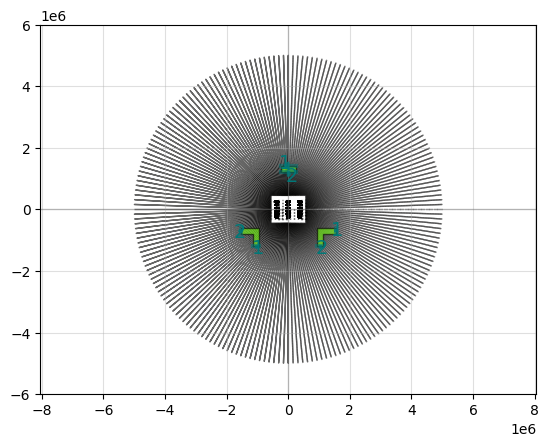

'.\\outputs\\v3.0.gds'

In [76]:
Final=Device()
Final << Design
Final << rad_guides(X,Y,fov,diameter=10e6)
Final << bot_left_mark(Design)
Final << bot_right_mark(Design)
Final << upper_mark(Design)

qp([Final])

Final.write_gds(r'.\outputs\v3.0.gds', unit=1e-9, precision=1e-11)